# Synthetic wedge

We're going to make the famous wedge model, which interpreters can use to visualize the tuning effect. Then we can extend the idea to other kinds of synthetic seismic.

## Make a simple earth model

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
width = 80  # x range
depth = 200  # z range

Recall that you can make a 2D NumPy array of zeros or ones using `np.zeros()` or `np.ones()` respectively, for example:

In [ ]:
np.zeros((5, 10))  # Rows, columns.

And you can mutate NumPy arrays like this:

In [ ]:
arr = np.ones((6, 4))
arr[3:] = 100  # This could also be a 1D array with 4 elements, or a 2D array shape 3x4.
arr

### EXERCISE

Make a 2-D NumPy array of integers with these dimensions, placing a boundary at a 'depth' of 66 and another at a depth of 133.

A plot of a vertical section through this array should look something like:

      |        <- 0's in this row
      |        <- 0
      --- 
        |      <- 1
        |      <- 1
        ---
          |    <- 2
          |    <- 2
          
There are a couple of ways to plot your result. Notice that by default the `imshow` plot has te origin at the top, whereas the `plot` has the origin at the bottom.

<img src="../assets/model_plots.png">

In [ ]:
# YOUR CODE HERE



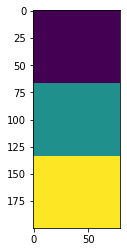

In [3]:
# We have to pass dtype=int or we get floats.
# We need ints because we're going to use this thing for indexing later.

def make_model(depth, width):
    """
    Build a wedge model.
    """
    model = np.zeros((depth, width), dtype=np.int8)
    model[depth//3:] = 1
    model[-depth//3:] = 2
    return model

# Another approach is to make a single 'log'
# then repeat is in the 'x' direction.
def make_model(depth, width):
    layer = depth // 3
    log = np.array((1 + layer)*[0] + (1 + layer)*[1] + layer*[2])
    model = np.repeat(log[:, None], width, axis=-1)
    return model

model = make_model(depth, width)

fig, ax = plt.subplots()
ax.imshow(model)
plt.show()

In [ ]:
# Jus tin case the question comes up.
fig, ax = plt.subplots()
im = ax.imshow(model)
cbar = plt.colorbar(im)
cbar.ax.invert_yaxis()  # To reverse the colorbar.
plt.show()

Now we can make some velocity–density $(V_\mathrm{P}, \rho)$ pairs for each rock type (rock index 0, index 1, and index 2).

In [4]:
rocks = np.array([[2540, 2550],   # <-- Upper layer
                  [2400, 2450],   # <-- Middle layer
                  [2650, 2800]])  # <-- Lower layer

Now we can use ['fancy indexing'](http://docs.scipy.org/doc/numpy/user/basics.indexing.html) to make `model`, which is an array of 0, 1, and 2, as the indices of the rock property pairs to 'grab' from `rocks`.

In [5]:
earth = rocks[model]

Now apply `np.prod` (product) to those velocity–density pairs to get impedance at every sample.

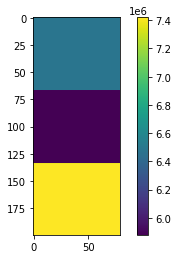

In [6]:
imp = earth[:, :, 0] * earth[..., 1]  # Optional use of ellipsis.

# Or, equivalently:
imp = np.prod(earth, axis=-1)

plt.imshow(imp)
plt.colorbar()

## Model seismic reflectivity

Now we have an earth model — giving us acoustic impedance everywhere in this 2D grid — we define a function to compute reflection coefficients for every trace.

### EXERCISE

Can you write a function to compute the reflection coefficients in this model?

It should implement this equation, where $Z$ is acoustic impedance and :

$$ R = \frac{Z_\mathrm{lower} - Z_\mathrm{upper}}{Z_\mathrm{lower} + Z_\mathrm{upper}} $$

The result should be a sparse 2D array _almost_ the same size and shape as the input. The upper interface should be negative.

**Look out** - depending on how you implement this, the output will probably be shorter (in depth) than the input, which can cause 'off by one' issues later, with plotting etc. One solution is to deal with it now, if you want to.

In [ ]:
def make_rc(imp):
    
    # YOUR CODE HERE
    
    return rc

rc = make_rc(imp)

In [ ]:
# This is almost useful, but there's no equivalent pairwise addition.
plt.imshow(np.diff(imp, axis=0))
plt.colorbar()

In [7]:
def make_rc(imp):
    """
    Compute reflection coefficients.
    """
    # It's a good idea to preserve the shape of the model.
    imp = np.pad(imp, pad_width=[(0, 1), (0, 0)], mode='edge')

    upper = imp[ :-1, :]
    lower = imp[1:  , :]
    
    return (lower - upper) / (lower + upper)
    
rc = make_rc(imp)

assert rc.shape == imp.shape

You should be able to plot the RC series like so:

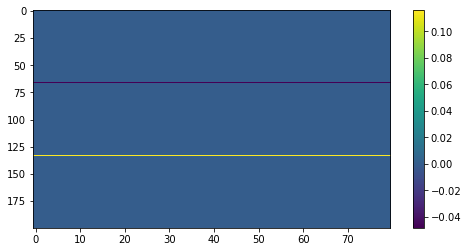

In [8]:
plt.figure(figsize=(8,4))
plt.imshow(rc, aspect='auto')
plt.colorbar()
plt.show()

We can also use `bruges` to make the reflectivity series. The catch is that we need the Vp and Rho models separately (and Vs, if we had this data). 

To retain the shape of the model, we can move the (Vp, Rho) axis to the front of the array with

    np.moveaxis(earth, -1, 0)
    
You could also do `np.rollaxis(earth, -1)` but I prefer the more general `moveaxis`. 

Once this axis is the first one, we can unpack into `vp` and `rho` variables, or use the unpacking operator `*` to give Vp and Rho directly to the function:

    bruges.reflection.acoustic_reflectivity(*np.moveaxis(earth, -1, 0))

In [10]:
import bruges

# Must be 0.4.4 at least.
bruges.__version__

'0.4.4'

/tmp/ipykernel_936267/348217431.py:2: FutureWarning: In future releases, mode will be 'same' by default.
  rc = bruges.reflection.acoustic_reflectivity(vp, rho, mode='same')


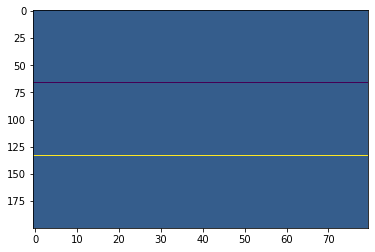

In [11]:
vp, rho = np.moveaxis(earth, -1, 0)
rc = bruges.reflection.acoustic_reflectivity(vp, rho, mode='same')

plt.figure(figsize=(6, 4))
plt.imshow(rc, aspect='auto', interpolation='none')
plt.show()

In [ ]:
rc.shape

## Model a seismic wavelet

### EXERCISE

Implement a Ricker wavelet of frequency $f$ with amplitude $\mathbf{a}$ at time $\mathbf{t}$ given by:

$$ \mathbf{a}(\mathbf{t}) = (1-2 \pi^2 f^2 \mathbf{t}^2) \mathrm{e}^{-\pi^2 f^2 \mathbf{t}^2} $$

The time parameter $\mathbf{t}$ will be an array of time samples in seconds, e.g. `[-0.008, -0.004, 0.000, 0.004, 0.008,...]`. It should be symmetrical about $t = 0$ and it should include a 0 point. You will need to know how long to make it, and what time step to use. So altogether you'll have three arguments.

**Note** that the time series is a bit fiddly. Ideally, you want to go from $-\frac12t$ to $+\frac12t$ inclusively, and have 0.0 at the centre. Experiment with `np.arange()` and `np.linspace()` to see if you can achieve this.

Pass both the wavelet and the timeseries back to the user. 

Make a plot of the wavelet's amplitude against time.

**Stretch goal:** supposing you wanted to be able to pass in an array of frequencies, like `f = [10, 20, 30, 40]`. How can you get your function to cope with that? <a title="See what happens if you multiply an array of shape (5,) by an array of shape (5, 1). Can you think of how to exploit this behaviour?"><b>HINT.</b></a>

In [ ]:
# YOUR CODE HERE



In [ ]:
np.arange(-1, 1, 0.2)

# Note the non-zero value at the centre, and the last step (1.0) is missing.

In [ ]:
np.linspace(-1, 1, 10)

# We need n+1 steps to get round 1/n steps.

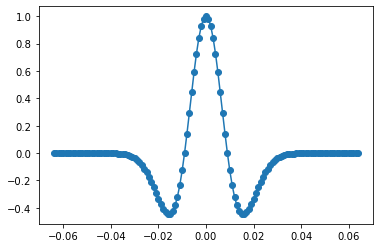

In [12]:
from collections import namedtuple

def ricker(duration, dt, f):
    """
    Ricker function.
    """
    # Leave this stretch goal until after demo'ing with scalar f.
    f = np.array(f).reshape(-1, 1)

    n = int(duration / dt) + 1
    t = np.linspace(-duration/2, duration/2, n)
    pft2 = (np.pi * f * t)**2
    w = (1 - 2 * pft2) * np.exp(-pft2)
    
    # Don't use a namedtuple the first time you demo this.
    Wavelet = namedtuple('Wavelet', ['amplitude', 'time'])

    return Wavelet(amplitude=np.squeeze(w), 
                   time = t)

f = np.arange(5, 100, 5)

w, t = ricker(duration=0.128, dt=0.001, f=25)

plt.plot(t, w, 'o-')

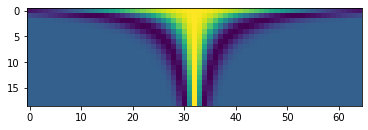

In [13]:
# After the stretch goal implementation, you can do this:
w, t = ricker(0.128, 0.002, f=np.arange(5, 100, 5))

plt.imshow(w)
plt.show()

There is [an implementation in `scipy.signal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ricker.html) but it has a 'width parameter' instead of 'frequency' so it's harder to parameterize.

Instead, we'll use `bruges` to make a wavelet:

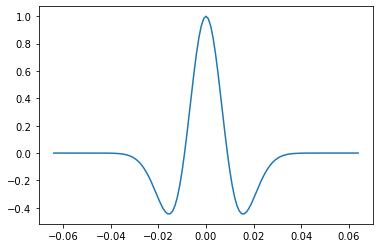

In [14]:
from bruges.filters import ricker

f = 25  # We'll use this later.
w, t = ricker(duration=0.128, dt=0.001, f=f, return_t=True, sym=True)

plt.plot(t, w)
plt.show()

## Make a 1D synthetic

### EXERCISE

We'll start with a 1D problem, using the first column of our model as the RC series.The task is to convolve it with the wavelet.

Pass the RC series to `np.convolve()` along with the wavelet, then plot the resulting synthetic seismogram.

In [ ]:
plt.plot(rc[:, 0])

In [ ]:
# YOUR CODE HERE



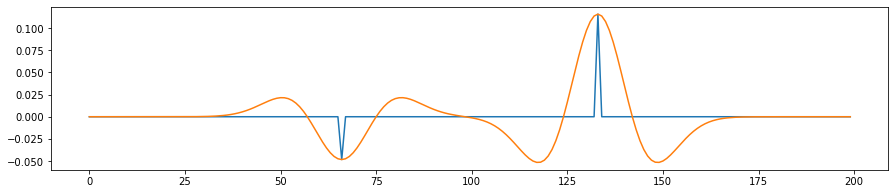

In [15]:
profile = rc[:, 0]
trace = np.convolve(profile, w, mode='same')

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(profile)
ax.plot(trace)

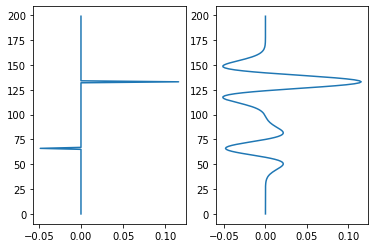

In [16]:
# A reminder how to put two panels in a plot.
# fig, axs = plt.subplots(ncols=2)
# OR:
fig, (ax0, ax1) = plt.subplots(ncols=2)

# Need this when we plot vertically.
y = np.arange(0, profile.size)

ax0.plot(profile, y)
ax1.plot(trace, y)
plt.show()

## A 2D synthetic

It's only a little trickier for us to apply 1D convolution to every trace in our 2D reflection coeeficient matrix. NumPy provides a function, `apply_along_axis()` to apply any function along any one axis of an n-dimensional array. I don't think it's much faster than looping, but I find it easier to think about.

Which axis? It's hard to remember and get it right first time, but ask yourself which dimension contains the size of the items you want? In our case, `axis=0`.

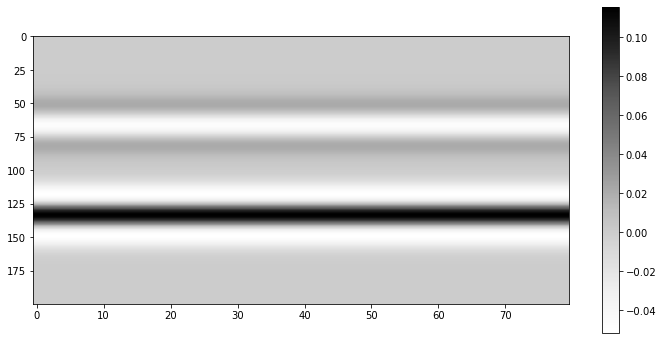

In [17]:
syn = np.apply_along_axis(np.convolve,
                          axis=0,
                          arr=rc,
                          v=w,         # kwarg for np.convolve
                          mode='same', # kwarg for np.convolve
                         )

plt.figure(figsize=(12,6))
plt.imshow(syn, cmap="Greys", aspect=0.2)
plt.colorbar()
plt.show()

### EXERCISE

Use `ipywidgets.interact` to turn this into an interactive plot, so that we can vary the frequency of the wavelet and see the effect on the synthetic.

Here's a reminder of how to use it:

    from ipywidgets import interact

    @interact(a=(0, 10, 1), b=(0, 100, 10))
    def main(a, b):
        """Do the things!"""
        print(a + b)
        return

In [18]:
# YOUR CODE HERE



In [19]:
from ipywidgets import interact

@interact(f=(6, 64, 2))
def show(f):
    w, t = ricker(duration=0.256, dt=0.001, f=f, return_t=True, sym=True)
    syn = np.apply_along_axis(np.convolve,
                              axis=0,
                              arr=rc,
                              v=w, mode='same')
    plt.figure(figsize=(12,6))
    plt.imshow(syn, cmap="Greys", aspect=0.2)
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=34, description='f', max=64, min=6, step=2), Output()), _dom_classes=('w…

In [20]:
# More options in case someone asks!
from ipywidgets import interact, widgets, Layout

style = {'description_width': 'initial'}
layout = Layout(width='500px')

slider = widgets.FloatSlider(value=0.05,
                             min=0, max=0.1, step=0.001,
                             readout_format='.3f',
                             description="The 2nd number",
                             style=style,
                             layout=layout,
                            )

@interact(a=(0, 10, 1), b=slider)
def main(a, b):
    """Do the things!"""
    print(a + b)
    return

# Slider 'a' has default properties.
# Slider 'b' has a long slider, and adjusted style to accommodate long description.

interactive(children=(IntSlider(value=5, description='a', max=10), FloatSlider(value=0.05, description='The 2n…

### EXERCISE

Can you make a composite plot showing:

- The model
- The synthetic — you can maybe overlay this on the model.
- A 'well': a trace from the model.
- The synthetic for the 'well'.

In [21]:
# YOUR CODE HERE



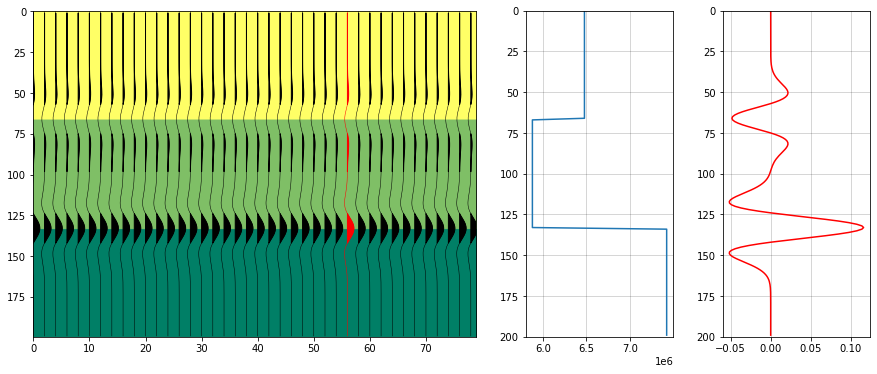

In [22]:
highlight = 56

fix, (ax1, ax2, ax3) = plt.subplots(ncols=3,
                                    figsize=(15, 6),
                                    gridspec_kw={'width_ratios': [3, 1, 1]}
                                   )

ax1.imshow(model, cmap='summer_r', aspect='auto')
for offset, trace in enumerate(syn.T[::2]):
    x2 = 2*offset
    x1 = x2 + 10*trace
    y = np.arange(trace.size)
    c = 'r' if x2 == highlight else 'k'
    ax1.fill_betweenx(y, x1, x2, where=x1-x2>0, interpolate=True, color=c)
    ax1.plot(x1, y, color=c, lw=0.5)
ax1.set_xlim(0, 79)

ax2.plot(imp[:, highlight], y)
ax2.set_ylim(200, 0)
ax2.grid(c='k', alpha=0.2)

ax3.plot(syn[:, highlight], y, 'r')
ax3.set_ylim(200, 0)
ax3.grid(c='k', alpha=0.2)

plt.show()

## A wedge model

### EXERCISE

Can you repeat this workflow (model > RC series > synthetic) for a wedge model instead of a layer cake?

In [ ]:
# YOUR CODE HERE



In [ ]:
model = 1 + np.tri(depth, width, k=1-depth//3, dtype=int)
#                                ^ adj. so left-most is thick=0.

plt.imshow(model)
plt.colorbar()
plt.show()

Now set the upper part of the model — above the wedge — to zero.

In [ ]:
model[:depth//3,:] = 0

plt.imshow(model)
plt.colorbar()
plt.show()

In [ ]:
# OPTIONAL: Add sides.
model = np.pad(model, [(0,), (width//4,)], mode='edge')

plt.imshow(model)
plt.colorbar()
plt.show()

In [ ]:
def make_wedge(depth, width):
    model = 1 + np.tri(depth, width, 1-depth//3, dtype=int)
    model[:depth//3,:] = 0
    
    # Optional extra bits at the sides.
    model = np.pad(model, [(0,), (width//4,)], mode='edge')

    return model

def make_syn(model, rocks, wavelet):
    earth = rocks[model]
    imp = np.apply_along_axis(np.prod, arr=earth, axis=-1)
    rc = make_rc(imp)
    syn = np.apply_along_axis(np.convolve, axis=0, arr=rc,
                              v=wavelet, mode='same')
    return syn

model = make_wedge(depth, width)
syn = make_syn(model, rocks, wavelet=w)

plt.figure(figsize=(12, 6))
plt.imshow(syn, cmap='gray', aspect='auto')

## Making wedges with `bruges`

As of version 0.4.2, `bruges` has a wedge builder. It's fairly flexible.

In [ ]:
from bruges.models import wedge

model, *_ = wedge(depth=(67, 67, 66),
                  width=(20, 80, 20),
                  breadth=None,
                  strat=(0, 1, 2),
                  thickness=(0.0, 1.0),
                  mode='linear',
                  conformance='proportional',
                  )

plt.figure(figsize=(10, 6))
plt.imshow(model, aspect='auto')
plt.show()

In [ ]:
model2, *_ = wedge(depth=(300, 400, 300),
                   width=(100, 800, 100),
                   breadth=None,
                   strat=([0, 1, 0], [1, 2, 1, 3, 3, 1], [4, 2, 1]),
                   thickness=(0.0, 1.0),
                   mode='sigmoid',
                   conformance='top',
                   )

plt.figure(figsize=(10, 6))
plt.imshow(model2, aspect='auto')
plt.colorbar()
plt.show()

### EXERCISE

Let's do some analysis on the synthetic.

- Plot the **position** of the _actual_ top of the wedge on the synthetic.
- Plot the **position** of the _apparent_ top of the wedge on the synthetic.

In a separate plot *in the same figure*:

- Plot the **amplitude** at the _actual_ top of the wedge.

In [ ]:
# BEFORE UNLEASHING THEM ON THIS EXERCISE...
# Students will need a way to get the apparent pick.
# See what ideas they have.

# Check the data:
syn = make_syn(model, rocks, wavelet=w)
one_trace = syn[:, 75]

# Naive way:
top_apparent = np.argmin(one_trace) # <-- Will need to constrain here.

plt.figure(figsize=(8, 4))
plt.plot(one_trace)
plt.axvline(top_apparent, c='r')

# How can you constrain to the first trough?
# How about just using one_trace[:80]

In [ ]:
# More elegant, but note that find_peaks()
# only works on 1D things.
import scipy.signal as ss

ss.find_peaks(one_trace, height=one_trace)

# Returns peaks and heights.
# Question: How can we make this give us troughs, not peaks?
# Answer: use the negative trace.

In [ ]:
# YOUR CODE HERE



In [ ]:
# Time of actual top.
t_actual = np.ones(syn.shape[-1]) * depth//3

# Time and amp of apparent top — naive approach.
t_apparent = np.argmin(syn[:depth//3+10, :], axis=0)
a_apparent = np.min(syn, axis=0)

In [ ]:
import scipy.signal as ss

horizon, amplitude = [], []
for trace in syn.T:
    # Use negative trace to find troughs.
    pos, amp = ss.find_peaks(-trace, height=trace)
    amp = amp['peak_heights']
    horizon.append(pos[0])   # Want the first (shallowest) peak.
    amplitude.append(amp[0]) # Corresponding amplitude.

gs = {'height_ratios': [1, 2]}
fig, (ax0, ax1) = plt.subplots(figsize=(16, 12), nrows=2, sharex=True, gridspec_kw=gs)
ax0.plot(amplitude, 'r')
ax1.imshow(syn, aspect='auto', cmap='Greys', vmin=-0.1, vmax=0.1)
ax1.plot(horizon, c='r')
ax1.plot(t_apparent, 'y--')
ax1.plot(t_actual, 'c')
ax1.set_xticklabels([0, 0, 0, 20, 40, 60, 80])  # Set x-axis labels to thickness.
ax1.set_xlabel('Wedge thickness (ms)')
ax0.set_title("Wedge model, {} Hz wavelet".format(f))
plt.show()

In [ ]:
# Probably don't want to get into this unless someone asks.
# Basically the problem is that find_peaks() only finds
# actual indices, whereas the real peak might be nearby.
data = np.array([-2, 1, 5, 10, 11, 4, -1, 0])

from welly.utils import parabolic

idx_parabolic, max_parabolic = parabolic(data, np.argmax(data))
idx_find_peaks, max_find_peaks = ss.find_peaks(data, height=data)

plt.plot(data, 'o-')
plt.plot(idx_parabolic, max_parabolic, '+', c='red', ms=12, label='parabolic')
plt.plot(idx_find_peaks[0], max_find_peaks['peak_heights'][0], '+', c='lime', ms=12, label='find_peaks')
plt.legend()

### EXERCISE

Some challenges:

1. Can you make a horizon for the bottom of the wedge?
1. Does the frequency affect the amplitude of the horizons? 
1. Try using some of the other wavelets in `bruges.filters`. Do they affect the horizons?
1. Use `bruges.reflection` to make a synthetic for offsets other than 0 deg. Can you make a synthetic gather? (You will need to make up or calculate a value for $V_\mathrm{S}$).

In [ ]:
# YOUR CODE HERE



In [ ]:
# TODO — Solutions for 1, 2, and 3 in that exercise.

In [ ]:
# Solution 4.
from bruges.reflection import reflectivity

rocks = np.array([[2540, 1340, 2550],
                  [2400, 1050, 2450],
                  [2650, 1380, 2800]])

earth = rocks[model]

vp, vs, rho = np.moveaxis(earth, -1, 0)

rc = np.stack([reflectivity(vp, vs, rho, theta=θ, mode='same') for θ in np.arange(60)])

syn = np.apply_along_axis(np.convolve, arr=rc, axis=1, v=w, mode='same')

plt.figure(figsize=(10, 6))
plt.imshow(syn[..., 60].T.real, aspect='auto')

## `xarray` is kinder

In [ ]:
# Can help to use xarray in situations like this:
import xarray as xr

a, t, i = map(np.arange, syn.shape)

syn_ = xr.DataArray(syn,
                    name='amplitude',
                    coords=[a, t, i],
                    dims=['angle', 'twt', 'inline']
                   )

inline = 79

syn_[..., inline].T.real.plot.imshow(origin='upper')

In [ ]:
angle = 20

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
syn_[angle].real.plot.imshow(ax=ax0, origin='upper', cmap='RdBu', vmin=-0.1, vmax=0.1)
ax0.axvline(inline, c='k', alpha=0.5)
syn_[..., inline].T.real.plot.imshow(ax=ax1, origin='upper', cmap='RdBu', vmin=-0.1, vmax=0.1)
ax1.axvline(angle, c='k', alpha=0.5)

## A really cool model

Let's load an image and use it as a model.

In [ ]:
import urllib
from PIL import Image

url = 'https://geocomp.s3.amazonaws.com/data/Hubbard_etal_2014.png'

img = Image.open(urllib.request.urlopen(url))

This is just a 4-channel PNG (red, green, blue, alpha).

In [ ]:
img

We need this as a NumPy array, and we can discard the alpha channel:

In [ ]:
import numpy as np

im = np.array(img)[..., :3]

There are various clustering algorithms we could use, but DBSCAN is optimized for runtime (just be careful about memory; if memory is an issue, use OPTICS).

Reshape the image pixels into a 2D array for `scikit-learn`, and reduce the number of points so we don't eat our memory:

In [ ]:
X = np.reshape(im, (-1, 3))[::50]

In [ ]:
from sklearn.cluster import DBSCAN

clu = DBSCAN(eps=0.1, min_samples=25, n_jobs=6)
clu.fit(X)

In [ ]:
colours = []
for label in np.unique(clu.labels_):
    if label == -1:
        continue  # Noisy values.
    sub = X[clu.labels_==label]
    colours.append(np.mean(sub, axis=0))

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=len(colours))
for ax, colour in zip(axs, colours):
    ax.imshow([[colour/255]])
    ax.axis('off')

Now we need to look up every pixel and choose the nearest of these, to assign it an integer

In [ ]:
from scipy.spatial import cKDTree

kdtree = cKDTree(colours)
dist, ix = kdtree.query(im)

In [ ]:
rocks = np.array([
    6477000,
    7420000,
    5880000,
    6800000,
    6100000,
    6400000,
])

In [ ]:
imp = rocks[ix]

imp

Alternatively, you could use something like a USGS colour table here: https://gist.github.com/kwinkunks/ea1f34e57d11ad17e340.

### EXERCISE

Make a synthetic from this "impedance" earth model.

In [ ]:
# YOUR CODE HERE



In [ ]:
rc = make_rc(imp)
synth = np.apply_along_axis(np.convolve,
                            axis=0,
                            arr=rc,
                            v=w, mode='same')

In [ ]:
plt.figure(figsize=(12, 6))
plt.imshow(synth, cmap="RdBu", vmin=-0.15, vmax=0.15)
plt.colorbar(shrink=0.3)
plt.show()

### EXERCISE

- Add some noise to the RC series, e.g. using `np.random.random()`.
- Smooth the synthetic in the x direction too, e.g. using `scipy.ndimage.gaussian_filter1d()`.
- Plot the synthetic with the model.
- Add a plot of a single trace at the side, with the location on the section.
- Make a model of your own!

In [ ]:
# YOUR CODE HERE 



In [ ]:
from scipy.ndimage import gaussian_filter1d

rc_n = rc + 0.01 * np.random.normal(size=rc.shape)

synth_v = np.apply_along_axis(np.convolve,
                              axis=0,
                              arr=rc_n,
                              v=w, mode='same')

synth = gaussian_filter1d(synth_v, sigma=4, axis=-1)

plt.figure(figsize=(12, 12))
plt.imshow(synth, cmap="RdBu", vmin=-0.1, vmax=0.1)
plt.colorbar(shrink=0.4)
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Scientific 2020</p>
</div>